In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

# This notebook will do the following:
1. Dataset analysis
2. Feature analysis (categorical and numerical if applicable)
3. Data missingness
4. Correlation analysis
5. Model training

# Dataset analysis
1. Shape
2. Data types
3. Column names

In [4]:
df.shape

(2190, 13)

In [5]:
df_test.shape

(730, 12)

In [6]:
df.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [7]:
df.dtypes

id                 int64
day                int64
pressure         float64
maxtemp          float64
temparature      float64
mintemp          float64
dewpoint         float64
humidity         float64
cloud            float64
sunshine         float64
winddirection    float64
windspeed        float64
rainfall           int64
dtype: object

In [8]:
df.duplicated().sum()

0

In [9]:
df.head(3)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1


In [10]:
df.tail(3)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1
2189,2189,365,1013.8,21.2,19.1,18.0,18.0,89.0,88.0,1.0,70.0,48.0,1


In [11]:
df.sample(3)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
1216,1216,122,1008.4,30.8,27.6,25.8,24.2,81.0,88.0,0.4,210.0,13.0,1
1455,1455,361,1016.4,16.3,16.6,15.9,15.0,91.0,96.0,0.0,70.0,37.0,1
1773,1773,314,1016.8,25.6,22.1,21.0,19.8,92.0,88.0,0.1,70.0,28.8,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB



# Observations
1. 11 features and 1 target
2. All features are numeric
3. Aside from day, all features are float values (non-categorical)
4. We will drop id


# Feature Analysis

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df.drop(columns='id').describe().style.background_gradient(cmap='cool')

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [15]:
df_test.drop(columns='id').describe().style.background_gradient(cmap='cool')

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,729.000000,730.000000
mean,183.000000,1013.503014,26.372466,23.963288,22.110274,20.460137,82.669863,76.360274,3.664384,103.923182,22.484247
std,105.438271,5.505871,5.672521,5.278098,5.170744,5.391169,7.818714,17.934121,3.639272,81.695458,9.954779
min,1.000000,1000.000000,7.400000,5.900000,4.200000,-0.000000,39.000000,0.000000,0.000000,10.000000,4.500000
25%,92.000000,1008.725000,21.600000,19.825000,17.825000,16.800000,77.250000,69.000000,0.325000,40.000000,14.500000
50%,183.000000,1012.700000,27.800000,25.650000,23.900000,22.300000,82.000000,83.000000,2.200000,70.000000,21.300000
75%,274.000000,1017.600000,31.000000,28.375000,26.400000,25.000000,89.000000,88.000000,6.675000,200.000000,28.400000
max,365.000000,1032.200000,35.800000,31.800000,29.100000,26.700000,98.000000,100.000000,11.800000,300.000000,59.500000


In [16]:
df['range'] = df['maxtemp'] - df['mintemp']
num_cols = df.columns

In [17]:
def num_col_analysis(df,cols):
    fig,axs = plt.subplots(len(cols),2,figsize=(10,len(cols)*3))
    for i,col in enumerate(cols):
        axs[i,0].set_title(f"Boxplot for {col}")
        sns.boxplot(df,x=col,ax=axs[i,0])
        axs[i,1].set_title(f"Histogram for {col}")
        sns.histplot(df,x=col,ax=axs[i,1],kde=True,hue='rainfall')
    plt.tight_layout()
    plt.show()

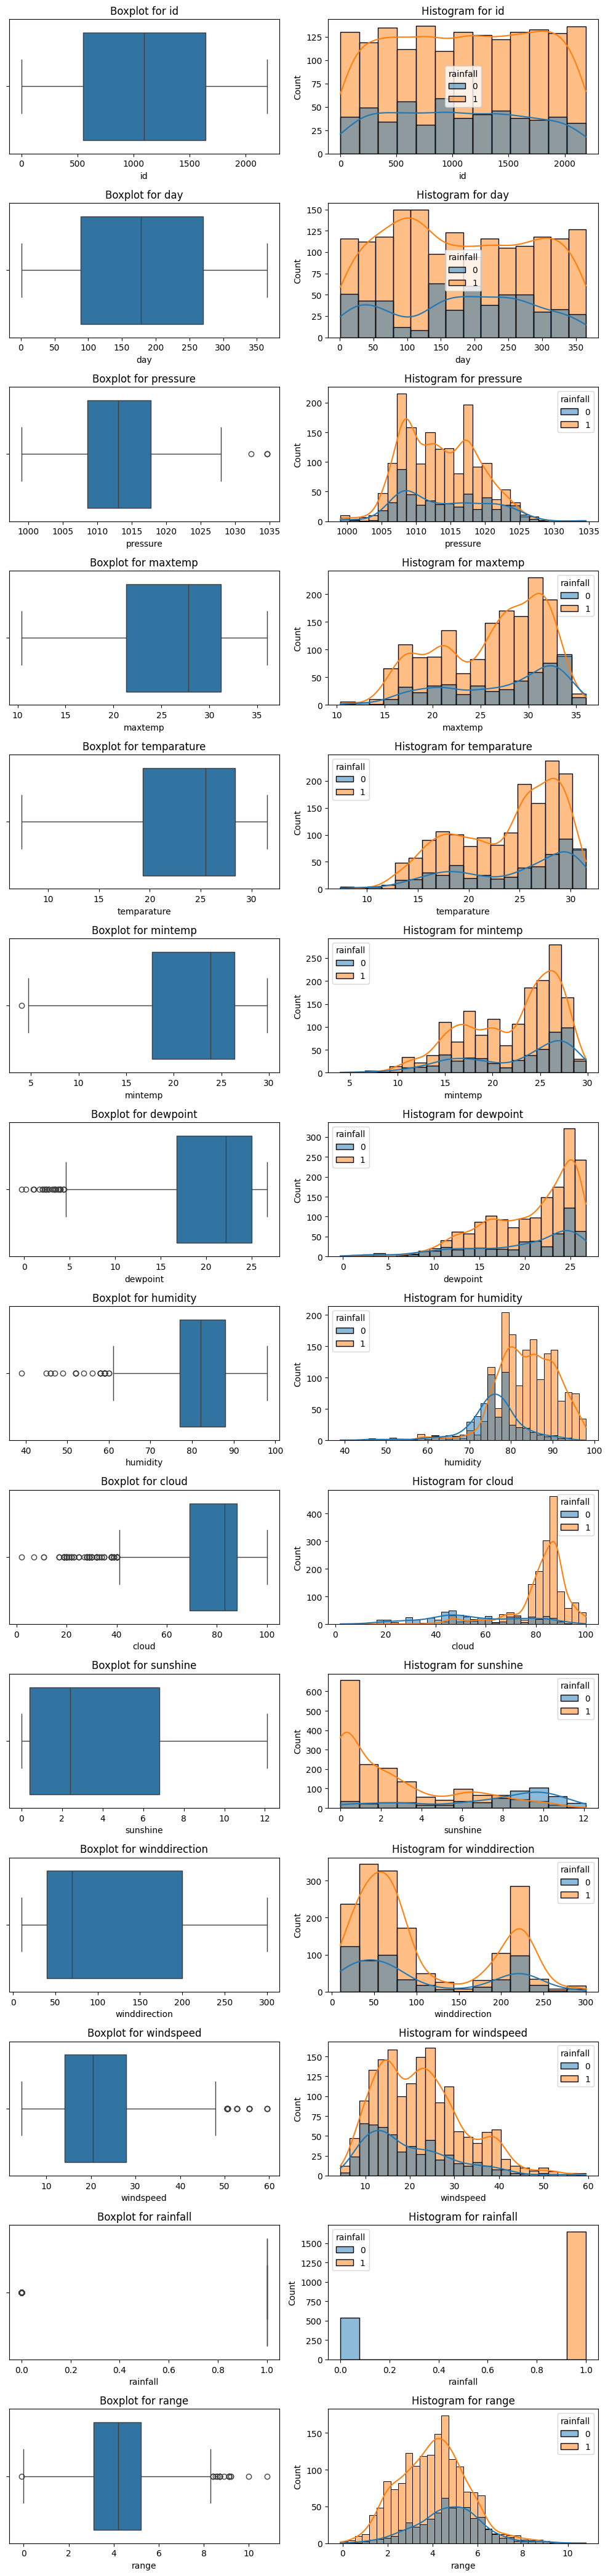

In [18]:
num_col_analysis(df,num_cols)

In [19]:
df_corr = df.drop(columns='id').corr()

<Axes: title={'center': 'Correlation Heatmap'}>

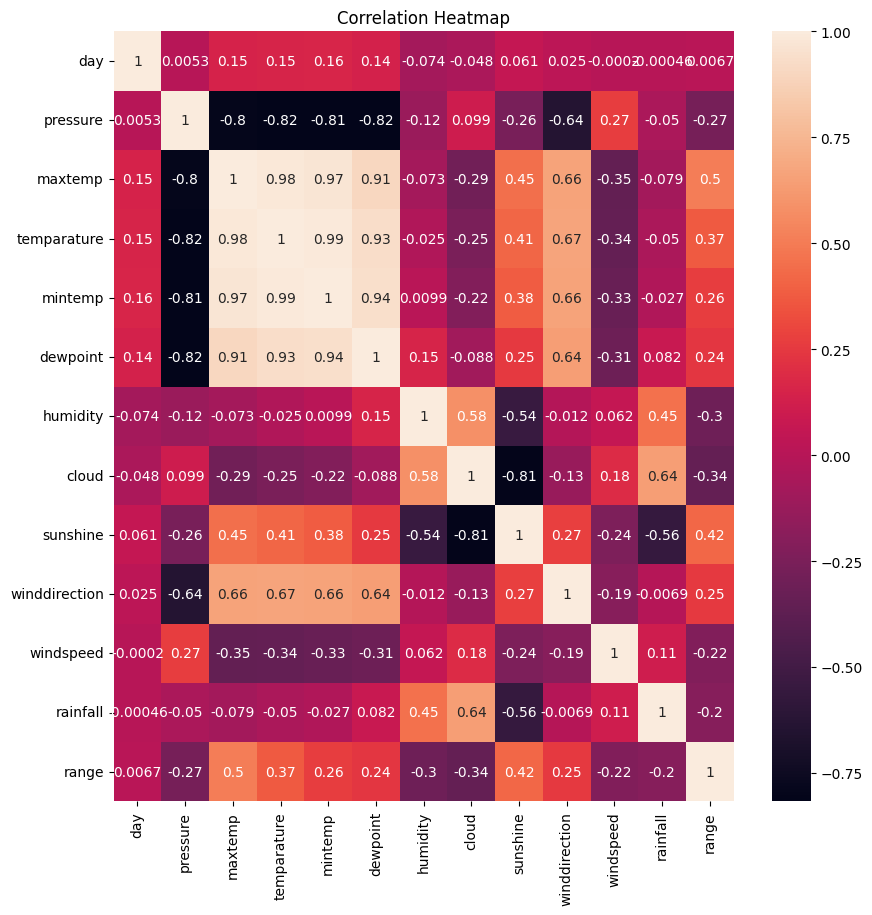

In [20]:
plt.figure(figsize=(10,10))
plt.title("Correlation Heatmap")
sns.heatmap(df_corr,annot=True)

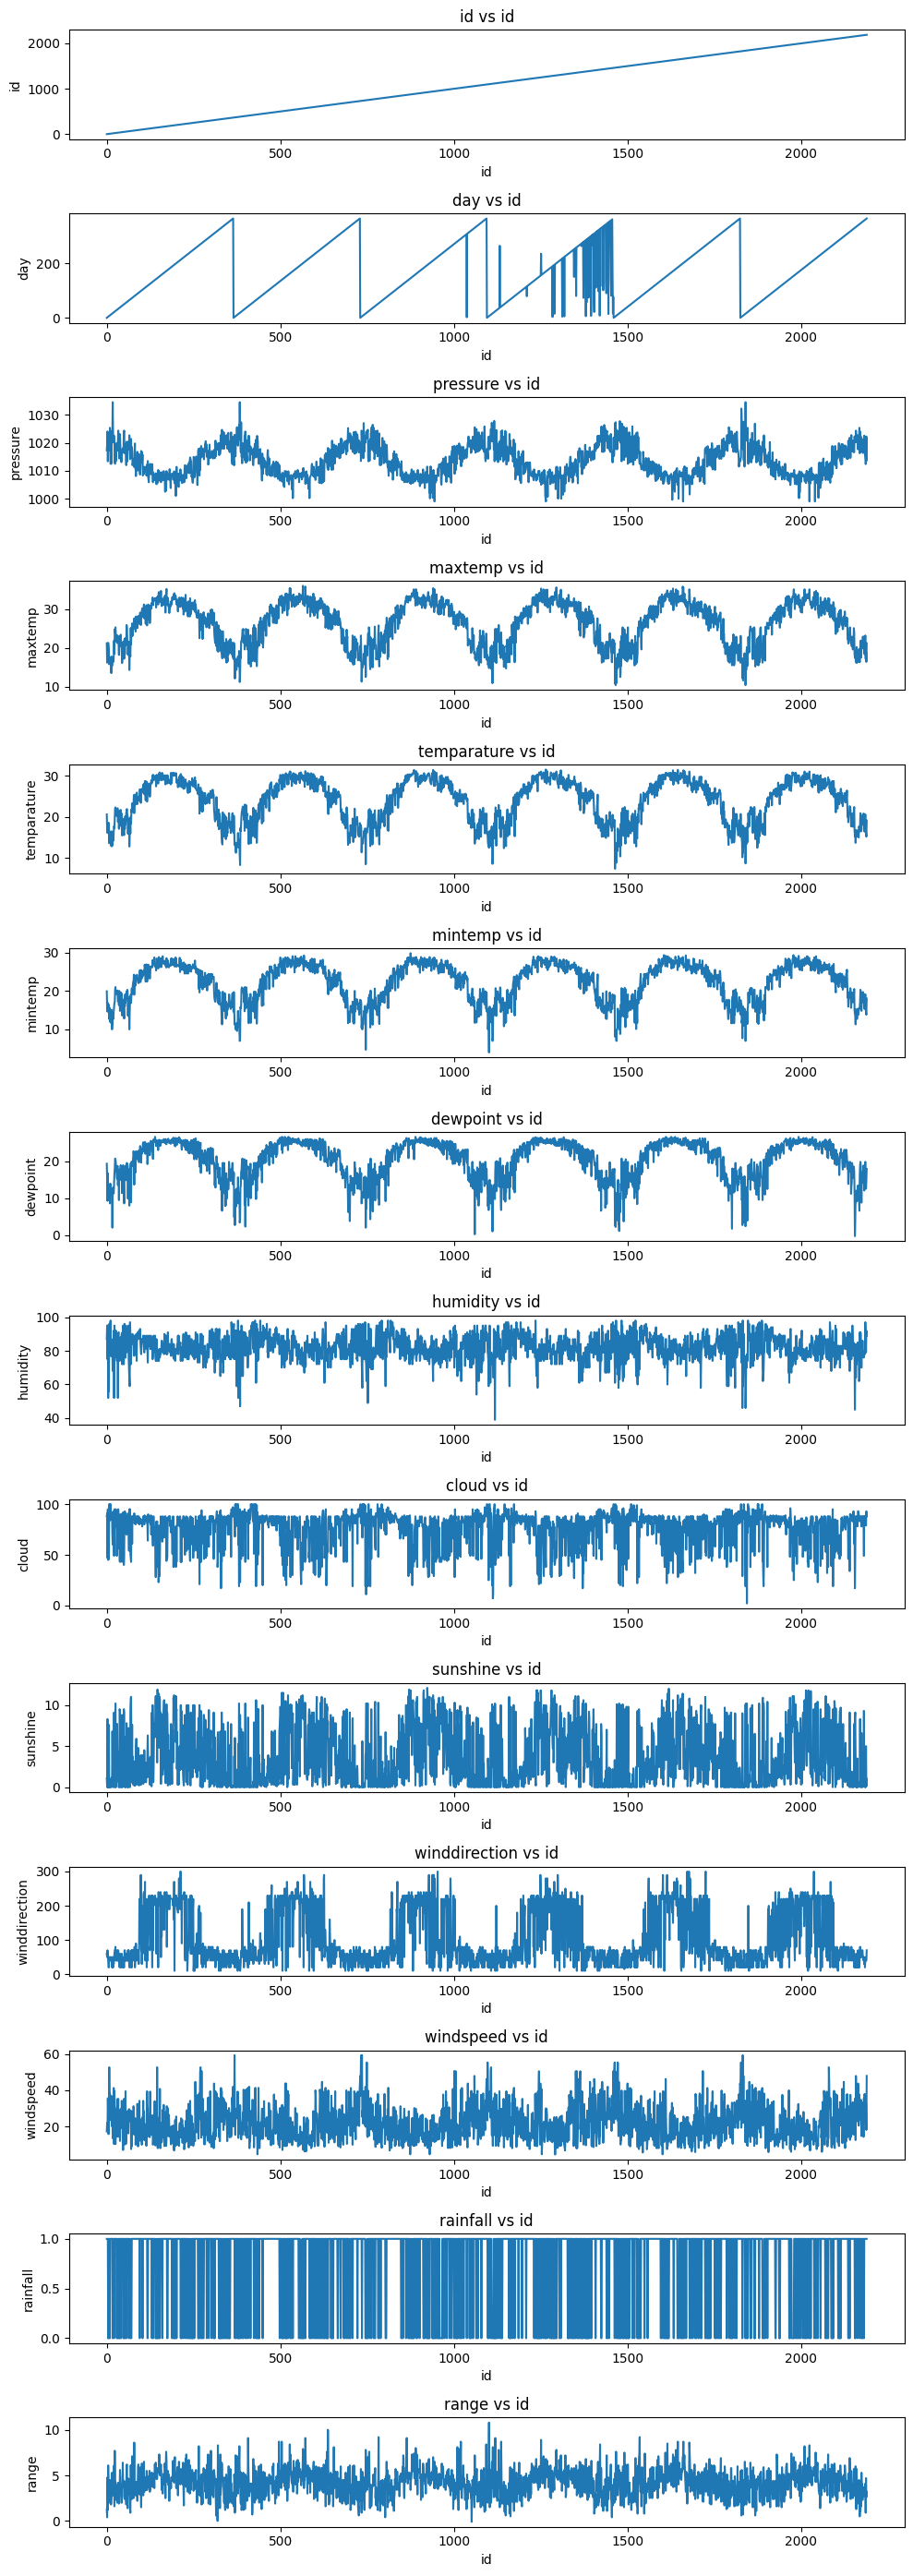

In [21]:

fig,axs = plt.subplots(len(num_cols),1,figsize=(10,2*len(num_cols)))
for i,col in enumerate(num_cols):
    axs[i].set_title(f'{col} vs id')
    sns.lineplot(df,x='id',y=col,ax=axs[i])
plt.tight_layout()
plt.show()

In [22]:
df.head(10)
df['range'] = df['maxtemp'] - df['mintemp']
display(df)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,range
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,1.3
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0.4
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,4.8
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,1.2
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1,4.1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1,0.9
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1,4.7
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1,2.6


# Observations
1. There are correlations between most features and even to each other
2. Very strong correlation between dewpoint and temperature, temperature and max/min temperature risking multi colinearity
3. Days follow a 1-365 cycle, with some exceptions --> Cyclic encoding will be beneficial
4. No missing values therefore no need to impute

# Preprocessing Function        

In [23]:
df.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall', 'range'],
      dtype='object')

In [37]:
def preprocessor(df):
    X = df.copy()
    # Calculate average of all temperatures (max/min/temp/dewpoint)
    X['avg_temp'] = (X['maxtemp'] + X['mintemp'] + X['temparature'] + X['dewpoint'])/4
    # Calculate range from max to min temperature
    X['range'] = X['maxtemp'] - X['mintemp']
    # Drop temp columns
    X.drop(columns=['maxtemp','mintemp','dewpoint','temparature','id'])

    # Create day_sin and day_cos
    X['day_sin'] = np.sin(2 * np.pi * X['day'] /365)
    X['day_cos'] = np.cos(2 * np.pi * X['day'] /365)
    return X


# Initialize Models and pipelines

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostClassifier

In [26]:
X = df.drop(columns=['rainfall'])
y = df['rainfall']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=43)

In [100]:
xgb_params = {
    "max_depth": 10,
    "learning_rate": 0.03,
    "n_estimators": 1000,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.5
}

In [104]:
xgb_param_grid = {
    "max_depth": [1,3,5,7,10],
    "learning_rate": [0.1,0.2,0.3,0.4],
    "n_estimators": [300,500,1000],
    "min_child_weight": [1,5,10],
    "subsample": [0.3,0.5,0.8,1],
    "colsample_bytree": [0.5,0.7,0.9]
}

In [101]:
model_xgb = xgb.XGBClassifier(**xgb_params)
model_cat = CatBoostClassifier()

def pipeline_stack(model):

    pipeline_final = Pipeline(steps = [
        ('Preprocessing', FunctionTransformer(preprocessor)),
        ('model',model)
    ])

    return pipeline_final

def pipeline_fit_and_evaluate(X_train,y_train,X_test,y_test,pipeline):
    pipeline.fit(X_train,y_train)
    y_preds = pipeline.predict(X_test)
    accuracy = accuracy_score(y_preds,y_test)
    return accuracy


In [102]:
xgb_pipeline = pipeline_stack(model_xgb)


In [52]:
cat_pipeline = pipeline_stack(model_cat)

In [103]:
xgb_acc = pipeline_fit_and_evaluate(X_train,y_train,X_test,y_test,xgb_pipeline)
print(xgb_acc)

0.8835616438356164


In [ ]:
cat_acc = pipeline_fit_and_evaluate(X_train,y_train,X_test,y_test,cat_pipeline)
print(cat_acc)